<a href="https://colab.research.google.com/github/komazawa-deep-learning/komazawa-deep-learning.github.io/blob/master/2022notebooks/2022_0512logistic_regression_and_MLP_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


ここでは 2 次元のおもちゃのニューラルネットワークの完全な実装を見て行きます。
まず単純な線形分類器を実装し，次にそのコードを 2 層のニューラルネットワークに拡張します。 
これから見るように，この拡張は驚くほど簡単で，ほとんど変更する必要はありません。
<!-- In this section we'll walk through a complete implementation of a toy Neural Network in 2 dimensions. 
We'll first implement a simple linear classifier and then extend the code to a 2-layer Neural Network. As we'll see, this extension is surprisingly simple and very few changes are necessary. -->

<a name='data'></a>

## 1. データ生成
<!-- ## Generating some data -->

線形分離が容易でない分類データセットを生成してみよう。
我々の好きな例は、スパイラルデータセットで、次のように生成できる。
<!-- Lets generate a classification dataset that is not easily linearly separable. 
Our favorite example is the spiral dataset, which can be generated as follows: -->


Text(0.5, 1.0, 'おもちゃの螺旋データは線形分離不可能な 3 つのクラス (青，赤，黄) で構成されている')

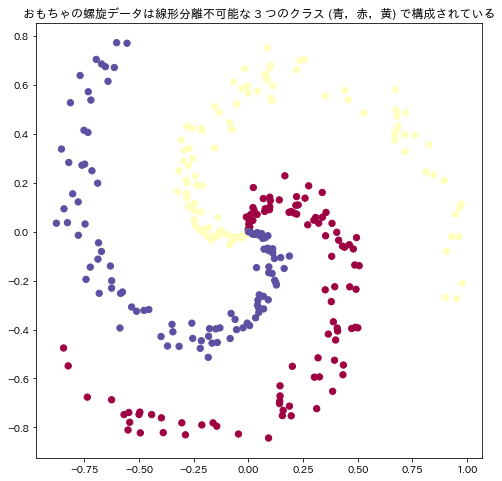

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import IPython
isColab = 'google.colab' in str(IPython.get_ipython())
if isColab:
    !pip install japanize_matplotlib
import japanize_matplotlib

plt.rcParams['figure.figsize'] = (8.0, 8.0)     # グラフ描画領域の設定，単位はインチ
plt.rcParams['image.interpolation'] = 'nearest'

N = 100 # 一クラスあたりのデータ数
D = 2   # 次元数
K = 3   # クラス数
X = np.zeros((N*K,D))            # データ行列 (一行に一データ)
y = np.zeros(N*K, dtype='uint8') # クラスのラベル，すなわち教師信号
for j in range(K):
    ix = range(N*j,N*(j+1))
    r = np.linspace(0.0,1,N) # radius
    t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = j
# lets visualize the data:
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.title('おもちゃの螺旋データは線形分離不可能な 3 つのクラス (青，赤，黄) で構成されている')


通常は各特徴が平均 0 と単位標準偏差を持つようにデータセットを前処理したいところです。
ですが，この場合，特徴はすでに -1〜1 のきれいな範囲にあるので，このステップは省略します。
<!-- Normally we would want to preprocess the dataset so that each feature has zero mean and unit standard deviation, but in this case the features are already in a nice range from -1 to 1, so we skip this step. -->

<a name='linear'></a>

## 2. ソフトマックス分類器の訓練 
<!-- Training a Softmax Linear Classifier -->

<a name='init'></a>

### 2.1 パラメータの初期化
<!-- Initialize the parameters -->

まず，このデータセットに対して ソフトマックス分類器を学習させましょう。
前節で見たように，ソフトマックス分類器は線形スコア関数を持ち，交差エントロピーの損失関数を利用します。
線形分類器のパラメータは，各クラスに対する重み行列 `W` とバイアスベクトル `b` から構成されます。
まず，これらのパラメータを乱数として初期化しましょう。
<!-- Lets first train a Softmax classifier on this classification dataset. 
As we saw in the previous sections, the Softmax classifier has a linear score function and uses the cross-entropy loss. 
The parameters of the linear classifier consist of a weight matrix `W` and a bias vector `b` for each class. Lets first initialize these parameters to be random numbers: -->


In [ ]:
# パラメータを乱数で初期化
W = 0.01 * np.random.randn(D,K)
b = np.zeros((1,K))


ここで `D = 2` が次元数，`K = 3` がクラス数であることを覚えておいてください。
<!-- Recall that we `D = 2` is the dimensionality and `K = 3` is the number of classes.  -->

<a name='scores'></a>

### 2.1. クラス得点の計算
<!-- ### Compute the class scores -->

作成するモデルは線形分類器ですので，1 回の行列の乗算ですべてのクラス得点を非簡単に計算することができます。
<!-- Since this is a linear classifier, we can compute all class scores very simply in parallel with a single matrix multiplication: -->


In [ ]:
# compute class scores for a linear classifier
scores = np.dot(X, W) + b

この例では 2 次元の点が 300 個あります。
この乗算後の配列 `scores` の大きさは  [300 x 3] となります。
各行には 3 つのクラス (青，赤，黄) に対応するクラスの得点が格納されます。
<!-- In this example we have 300 2-D points, so after this multiplication the array `scores` will have size [300 x 3], where each row gives the class scores corresponding to the 3 classes (blue, red, yellow). -->

<a name='loss'></a>

### 2.2 損失値の計算
<!-- ### Compute the loss -->

2 番目に重要な要素は損失関数です。
これは計算されたクラス得点を使用して不幸を定量化する微分可能な目的関数です。
直感的には正しいクラスが他のクラスより高い得点になっていることが望ましいのです。
このときの損失値は小さくなり，そうでない場合は大きくなります。
この直感を定量化する方法はたくさんありますが，この例ではソフトマックス分類器に関連する交差エントロピーの損失を使用することにします。 
ある 1 つの事例に対するクラス得点の配列 (ここでは一行に 3 つの数値をもつ配列) を $f(x)$  とするとソフトマックス分類器はその例に対する損失値を次のように計算することになります:
<!-- The second key ingredient we need is a loss function, which is a differentiable objective that quantifies our unhappiness with the computed class scores. 
Intuitively, we want the correct class to have a higher score than the other classes. 
When this is the case, the loss should be low and otherwise the loss should be high. 
There are many ways to quantify this intuition, but in this example lets use the cross-entropy loss that is associated with the Softmax classifier. Recall that if \\(f\\) is the array of class scores for a single example (e.g. array of 3 numbers here), then the Softmax classifier computes the loss for that example as: -->

$$
L_i = -\log\left(\frac{e^{f_{y_i}}}{ \sum_j e^{f_j} }\right)
$$

ソフトマックス分類器は $f$ の各要素を 3 つのクラスの (非正規化) 対数確率を保持していると解釈していることがわかります。
これらを指数化して (非正規化) 確率を求め，正規化して確率を求めます。
したがって log の中の式は正しいクラスの正規化された確率となります。
この式の仕組みに注意してください。この量は常に 0 と 1 の間にあります。
正しいクラスの確率が非常に小さい (0 に近い) 場合，損失値は (正の) 無限大の方向に進みます。
逆に，正しいクラスの確率が 1 に近づくと $\log(1)=0$ となり，損失値は 0 に近づきます。
したがって，正しいクラス確率が高いとき $L_{i}$ の式は小さくなり，低い場合は $L_{i}$ の値は非常に大きくなります。
<!-- We can see that the Softmax classifier interprets every element of $f$ as holding the (unnormalized) log probabilities of the three classes. We exponentiate these to get (unnormalized) probabilities, and then normalize them to get probabilites. 
Therefore, the expression inside the log is the normalized probability of the correct class. 
Note how this expression works: this quantity is always between 0 and 1. 
When the probability of the correct class is very small (near 0), the loss will go towards (postiive) infinity. Conversely, when the correct class probability goes towards 1, the loss will go towards zero because $log(1) = 0\$. 
Hence, the expression for \\(L_i\\) is low when the correct class probability is high, and it's very high when it is low.  -->

また，ソフトマックス分類器の損失値は，学習例と正則化に対する平均交差エントロピー損失として定義されることを覚えておいてください。
<!-- Recall also that the full Softmax classifier loss is then defined as the average cross-entropy loss over the training examples and the regularization: -->

$$
L = \underbrace{\frac{1}{N}\sum_i L_i }_\text{データ損失} + \underbrace{\frac{1}{2} \lambda \sum_k\sum_l W_{k,l}^2 }_\text{正規化損失値} \\
$$

上で計算した `scores` の配列があれば，損失値を計算することができます。
まず，確率の求め方は簡単です。
<!-- Given the array of `scores` we've computed above, we can compute the loss. 
First, the way to obtain the probabilities is straight forward: -->


In [ ]:
# 正規化されていない得点
exp_scores = np.exp(scores)

# 各事例に対する得点を正規化して確率に変換
probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

これで大きさ [300 x 3] の配列 `probs` ができあがりました。
各行にはクラスの確率が格納されます。
特に，正規化したので，各行の合計は 1 になります。
これで，各例で正しいクラスに割り当てられた対数確率を問い合わせることができます。
<!-- We now have an array `probs` of size [300 x 3], where each row now contains the class probabilities. In particular, since we've normalized them every row now sums to one. 
We can now query for the  log probabilities assigned to the correct classes in each example: -->


In [ ]:
num_examples = X.shape[0]
corect_logprobs = -np.log(probs[range(num_examples),y])

配列 `correct_logprobs` は各例に対して正しいクラスに割り当てられた確率だけを集めた 1次元配列です。
全損失は，これらの対数確率と正則化損失の平均です。
<!-- The array `correct_logprobs` is a 1D array of just the probabilities assigned to the correct classes for each example. The full loss is then the average of these log probabilities and the regularization loss:-->


In [ ]:
# ハイパーパラメータの設定
step_size = 1e-0
_lambda = 1e-3 # regularization strength

# 損失値の計算: 平均交差エントロピーと正則化項との和
data_loss = np.sum(corect_logprobs)/num_examples
reg_loss = 0.5 * _lambda * np.sum(W*W)
loss = data_loss + reg_loss

このコードでは 正則化強度の $\lambda$ が `_lambda` として格納されています。
`0.5`という正則化の倍率が便利なのは，すぐにわかるでしょう。
これは `np.log(1.0/3)` であり，小さな初期乱数重みでは，全てのクラスに割り当てられる確率は約 3 分の 1 になるからです。
ここで，損失値をできるだけ小さくしたいと考え `loss = 0`を絶対的な下限とします。
しかし，損失が小さいほど，すべての例について正しいクラスに割り当てられる確率が高くなります。
<!-- In this code, the regularization strength $\lambda$ is stored inside the `_lambda`. 
The convenience factor of `0.5` multiplying the regularization will become clear in a second. 
Evaluating this in the beginning (with random parameters) might give us `loss = 1.1`, which is `np.log(1.0/3)`, since with small initial random weights all probabilities assigned to all classes are about one third. We now want to make the loss as low as possible, with `loss = 0` as the absolute lower bound. 
But the lower the loss is, the higher are the probabilities assigned to the correct classes for all examples. -->

<a name='grad'></a>

### 2.3 誤差逆伝播法による解析的勾配の計算
<!-- ### Computing the Analytic Gradient with Backpropagation-->

損失を評価する方法ができたので，次はそれを最小化する必要があります。
そのために勾配降下法を使います。
つまり，ランダムなパラメータ (上図参照) から始めて，パラメータに対する損失関数の勾配を評価し，損失を減らすためにパラメータをどのように変更すればよいかを知ることができるのです。
ここで，中間変数 $p$ を導入します。
これは (正規化された) 確率ベクトルです。
ある事例の損失値は以下のようになります:
<!--
We have a way of evaluating the loss, and now we have to minimize it. 
We'll do so with gradient descent. 
That is, we start with random parameters (as shown above), and evaluate the gradient of the loss function with respect to the parameters, so that we know how we should change the parameters to decrease the loss. 
Lets introduce the intermediate variable $(p$, which is a vector of the (normalized) probabilities. 
The loss for one example is: -->

$$
p_k = \frac{e^{f_k}}{ \sum_j e^{f_j} } \hspace{1in} L_i =-\log\left(p_{y_i}\right)
$$

ここで，この事例が全目的関数に寄与する損失値 $L_i$ を減少させるため，$f$ 内部の計算された得点がどのように変化すべきかを理解したいとしましょう。
すなわち，勾配 $\partial L_{i} / \partial f_{k}$ を導出したいのです。
損失値 $L_{i}$ は $p$ から計算されますが，これは $f$ に依存します。
合成関数の微分公式を使って勾配を導くのは読者にとって楽しい練習ですが，いろいろなことが相殺されて，最終的には極めて簡潔で解釈しやすいことがわかります。
<!-- We now wish to understand how the computed scores inside $f$ should change to decrease the loss $L_i$ that this example contributes to the full objective. 
In other words, we want to derive the gradient $\partial L_{i} / \partial f_{k}$. 
The loss $L_i$ is computed from $p$, which in turn depends on $f$. 
It's a fun exercise to the reader to use the chain rule to derive the gradient, but it turns out to be extremely simple and interpretible in the end, after a lot of things cancel out: -->

$$
\frac{\partial L_i }{ \partial f_k } = p_k - \mathbb{1}(y_i = k)
$$

この式がいかにエレガントで簡潔であるかに注目してください。
我々が計算した確率が `p = [0.2, 0.3, 0.5]` で，正しいクラスは (確率 0.3 の) 真ん中のクラスであったと仮定します。
この導出によれば，得点の勾配は `df = [0.2, -0.7, 0.5]` となります。
得点ベクトル `f` の最初か最後の要素 (不正確なクラスの得点) を増やすと，損失が **増大** します (
正の符号  +0.2 と +0.5 のため)  ーーー そして損失の増大は，予想通り悪いことです。
<!-- Notice how elegant and simple this expression is. 
Suppose the probabilities we computed were `p = [0.2, 0.3, 0.5]`, and that the correct class was the middle one (with probability 0.3). 
According to this derivation the gradient on the scores would be `df = [0.2, -0.7, 0.5]`. 
Recalling what the interpretation of the gradient, we see that this result is highly intuitive: increasing the first or last element of the score vector `f` (the scores of the incorrect classes) leads to an *increased* loss (due to the positive signs +0.2 and +0.5) - and increasing the loss is bad, as expected. -->

しかし，正しいクラスの得点を上げると，損失値に対して **負** の影響を及ぼします。
勾配が -0.7 ということは，正しいクラスの得点を上げると損失 $L_{i}$ が減るということであり，これは理にかなっています。
<!-- However, increasing the score of the correct class has *negative* influence on the loss. 
ppThe gradient of -0.7 is telling us that increasing the correct class score would lead to a decrease of the loss $L_{i}$, which makes sense.-->

これらのことは，以下のコードに集約されます。
`probs` は各例に対する全クラスの確率を (行として) 保存していることを思い出してください。
得点の勾配を求めるためには `dscores` を次のように進めます。
<!-- All of this boils down to the following code. Recall that `probs` stores the probabilities of all classes (as rows) for each example. 
To get the gradient on the scores, which we call `dscores`, we proceed as follows: -->


In [ ]:
dscores = probs
dscores[range(num_examples),y] -= 1
dscores /= num_examples

最後に `scores = np.dot(X, W) + b` があったので `dscores` に格納されている `scores` の勾配を利用して `W` と `b` に誤差逆伝播することができます。
<!-- Lastly, we had that `scores = np.dot(X, W) + b`, so armed with the gradient on `scores` (stored in `dscores`), we can now backpropagate into `W` and `b`: -->


In [ ]:
dW = np.dot(X.T, dscores)
db = np.sum(dscores, axis=0, keepdims=True)
dW += _lambda * W    # 正則化項の勾配

ここで，行列の乗算演算を誤差逆伝播し，さらに正則化の寄与を追加していることがわかります。
正則化勾配は，損失寄与に定数 `0.5` を用いたので，非常に単純な形 `_lambda * W` であることに注意してください  (i.e. $\displaystyle\frac{d}{dw} \left( \frac{1}{2}\lambda w^2\right) =\lambda w$). 
これは勾配式を簡単にするよくある便宜的なトリックです。
<!-- Where we see that we have backpropped through the matrix multiply operation, and also added the contribution from the regularization. 
Note that the regularization gradient has the very simple form `reg*W` since we used the constant `0.5` for its loss contribution (i.e. $\displaystyle\frac{d}{dw} \left( \frac{1}{2}\lambda w^2\right) =\lambda w$. 
This is a common convenience trick that simplifies the gradient expression. -->

<a name='update'></a>

### 2.4 パラメータ更新の実行
<!-- ### 2.4 Performing a parameter update-->

勾配を評価したことで，すべてのパラメータが損失関数にどのように影響するかがわかりました。
ここで，損失を **減らす** ために，**負の勾配方向** にパラメータ更新を実行することにします。
<!-- Now that we've evaluated the gradient we know how every parameter influences the loss function. 
We will now perform a parameter update in the *negative* gradient direction to *decrease* the loss: -->


In [ ]:
# パラメータの更新
W += -step_size * dW
b += -step_size * db


<a name='together'></a>

### ソフトマックス分類器の全部盛り
<!-- Putting it all together: Training a Softmax Classifier -->

これらをまとめると、勾配降下法を用いたソフトマックス分類器の学習コードの全容は次のようになります。
<!-- Putting all of this together, here is the full code for training a Softmax classifier with Gradient descent: -->



In [ ]:
#Train a Linear Classifier

# initialize parameters randomly
W = 0.01 * np.random.randn(D,K)
b = np.zeros((1,K))

# some hyperparameters
step_size = 1e-0
_lambda = 1e-3  # regularization strength

# gradient descent loop
num_examples = X.shape[0]
for i in range(200):
  
    # evaluate class scores, [N x K]
    scores = np.dot(X, W) + b 
  
    # compute the class probabilities
    exp_scores = np.exp(scores)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]
  
    # compute the loss: average cross-entropy loss and regularization
    corect_logprobs = -np.log(probs[range(num_examples),y])
    data_loss = np.sum(corect_logprobs)/num_examples
    reg_loss = 0.5 * _lambda * np.sum(W*W)
    loss = data_loss + reg_loss
    if i % 10 == 0:
        print(f"繰り返し回数 {i:3d}: 損失値:{loss:.3f}")
  
    # compute the gradient on scores
    dscores = probs
    dscores[range(num_examples),y] -= 1
    dscores /= num_examples
  
    # backpropate the gradient to the parameters (W,b)
    dW = np.dot(X.T, dscores)
    db = np.sum(dscores, axis=0, keepdims=True)
  
    dW += _lambda * W # regularization gradient
  
    # perform a parameter update
    W += -step_size * dW
    b += -step_size * db


結果は次のようになるでしょう:
<!-- Running this prints the output: -->

```
繰り返し回数   0: 損失値:1.099
繰り返し回数  10: 損失値:0.911
繰り返し回数  20: 損失値:0.841
繰り返し回数  30: 損失値:0.810
繰り返し回数  40: 損失値:0.794
繰り返し回数  50: 損失値:0.784
繰り返し回数  60: 損失値:0.779
繰り返し回数  70: 損失値:0.776
繰り返し回数  80: 損失値:0.773
繰り返し回数  90: 損失値:0.772
繰り返し回数 100: 損失値:0.771
繰り返し回数 110: 損失値:0.770
繰り返し回数 120: 損失値:0.770
繰り返し回数 130: 損失値:0.769
繰り返し回数 140: 損失値:0.769
繰り返し回数 150: 損失値:0.769
繰り返し回数 160: 損失値:0.769
繰り返し回数 170: 損失値:0.769
繰り返し回数 180: 損失値:0.769
繰り返し回数 190: 損失値:0.769
```

約 200 回の反復の後，何かに収束したことがわかります。
訓練データセットの精度を評価することができます。
<!-- We see that we've converged to something after about 190 iterations. We can evaluate the training set accuracy: -->



In [ ]:
# evaluate training set accuracy
scores = np.dot(X, W) + b
predicted_class = np.argmax(scores, axis=1)
print(f'訓練精度: {np.mean(predicted_class == y):.2f}%')


これは **49%**と表示されます。
あまり良い結果ではありませんが，データセットが線形分離できないように構成されていることを考えると，驚くことではありません。
また，学習された判定境界をプロットすることもできます。
<!-- This prints 49%. Not very good at all, but also not surprising given that the dataset is constructed so it is not linearly separable. We can also plot the learned decision boundaries: -->

In [ ]:
# plot the resulting classifier
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = np.dot(np.c_[xx.ravel(), yy.ravel()], W) + b
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)
fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
#fig.savefig('spiral_linear.png')



<a name='net'></a>

## 3. ニューラルネットワークによる訓練
<!-- ## Training a Neural Network -->

明らかに，線形分類器はこのデータセットには不適当であり，我々はニューラルネットワークを使いたいと考えています。
このおもちゃデータでは隠れ層を 1 つ追加すれば十分です。
ここで，重みとバイアスを 2 セット (第 1 層と第 2 層) 必要とします。
<!-- Clearly, a linear classifier is inadequate for this dataset and we would like to use a Neural Network. 
One additional hidden layer will suffice for this toy data. 
We will now need two sets of weights and biases (for the first and second layers): -->


In [ ]:
# パラメータを乱数で初期化する
h = 100             # 中間層のニューロン数
W = 0.01 * np.random.randn(D,h)
b = np.zeros((1,h))
W2 = 0.01 * np.random.randn(h,K)
b2 = np.zeros((1,K))

得点を計算する順向きパスの形が変わりました。
<!-- The forward pass to compute scores now changes form: -->


In [ ]:
# evaluate class scores with a 2-layer Neural Network
hidden_layer = np.maximum(0, np.dot(X, W) + b) # note, ReLU activation
scores = np.dot(hidden_layer, W2) + b2

以前からの唯一の変更は 1 行の追加コードで，最初に隠れ層の表現を計算し，次にこの隠れ層に基づく得点を計算していることに注意してください。
重要なのは，非線形性を追加したことです。
この場合は単純な ReLU で，隠れ層の活性度をゼロで閾値付けします。
<!-- Notice that the only change from before is one extra line of code, where we first compute the hidden layer representation and then the scores based on this hidden layer. 
Crucially, we've also added a non-linearity, which in this case is simple ReLU that thresholds the activations on the hidden layer at zero.-->

その他はすべて同じです。
前と全く同じように得点に基づいて損失を計算し，前と全く同じように得点 `dscores` の勾配を求めます。
しかし，その勾配をモデルパラメータに誤差逆伝播する方法は，当然ながら形を変えます。まず，ニューラルネットワークの 2 層目を誤差逆伝播してみましょう。
これはソフトマックス分類器のコードと同じですが，変数 `X` (生データ) を `hidden_layer`) に置き換えています。
<!-- Everything else remains the same. 
We compute the loss based on the scores exactly as before, and get the gradient for the scores `dscores` exactly as before. 
However, the way we backpropagate that gradient into the model parameters now changes form, of course. First lets backpropagate the second layer of the Neural Network. 
This looks identical to the code we had for the Softmax classifier, except we're replacing `X` (the raw data), with the variable `hidden_layer`): -->


In [ ]:
# backpropate the gradient to the parameters
# first backprop into parameters W2 and b2
dW2 = np.dot(hidden_layer.T, dscores)
db2 = np.sum(dscores, axis=0, keepdims=True)

なぜなら `hidden_layer` 自身が他のパラメータとデータの関数だからです。
でも，先ほどとは異なり，まだ終わっていません。
この変数を通して誤差逆伝播を継続する必要があります。
その勾配は次のように計算されます。
<!-- However, unlike before we are not yet done, because `hidden_layer` is itself a function of other parameters and the data! We need to continue backpropagation through this variable. 
Its gradient can be computed as: -->



In [ ]:
dhidden = np.dot(dscores, W2.T)

これで隠れ層の出力に勾配がつきました。
次に ReLU の非線形性を誤差逆伝播する必要があります。
これは簡単なことで，逆向きパスの ReLU は事実上スイッチであることがわかります。
$r=\max(0, x)$ なので $\frac{dr}{dx}=1(x > 0)$ となることがわかります。
合成関数の微分法則と組み合わせて ReLU ユニットは，入力が 0 より大きかったら勾配を変更せずに通過させます。
ですが，前向きパスの間に入力が 0 より小さかったら **抹消**  されることがわかります。
従って ReLU をそのまま誤差逆伝播することは，次のように簡単にできます。
<!-- Now we have the gradient on the outputs of the hidden layer. 
Next, we have to backpropagate the ReLU non-linearity. 
This turns out to be easy because ReLU during the backward pass is effectively a switch. 
Since $r = max(0, x)$, we have that $\frac{dr}{dx} = 1(x > 0)$. 
Combined with the chain rule, we see that the ReLU unit lets the gradient pass through unchanged if its input was greater than 0, but *kills it* if its input was less than zero during the forward pass. 
Hence, we can backpropagate the ReLU in place simply with: -->


In [ ]:
# backprop the ReLU non-linearity
dhidden[hidden_layer <= 0] = 0

そして、いよいよ 1 層目の重みと偏りに続きます。


In [ ]:
# finally into W,b
dW = np.dot(X.T, dhidden)
db = np.sum(dhidden, axis=0, keepdims=True)


これで完了です。
勾配 `dW,db,dW2,db2` を取得し，パラメータの更新を実行することができます。
他のすべては変更されないままです。
完全なコードは非常によく似ています。
<!-- We're done! 
We have the gradients `dW,db,dW2,db2` and can perform the parameter update. 
Everything else remains unchanged. The full code looks very similar: -->


In [ ]:
# initialize parameters randomly
h = 100 # size of hidden layer
W = 0.01 * np.random.randn(D,h)
b = np.zeros((1,h))
W2 = 0.01 * np.random.randn(h,K)
b2 = np.zeros((1,K))

# some hyperparameters
step_size = 1e-0
_lambda = 1e-3 # regularization strength

# gradient descent loop
num_examples = X.shape[0]
for i in range(10000):
  
    # evaluate class scores, [N x K]
    hidden_layer = np.maximum(0, np.dot(X, W) + b) # note, ReLU activation
    scores = np.dot(hidden_layer, W2) + b2
  
    # compute the class probabilities
    exp_scores = np.exp(scores)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]
  
    # compute the loss: average cross-entropy loss and regularization
    corect_logprobs = -np.log(probs[range(num_examples),y])
    data_loss = np.sum(corect_logprobs)/num_examples
    reg_loss = 0.5 * _lambda * np.sum(W*W) + 0.5 * _lambda * np.sum(W2*W2)
    loss = data_loss + reg_loss
    if i % 1000 == 0:
        print(f"繰り返し回数:{i:4d} 損失値: {loss:.3f}")
  
    # compute the gradient on scores
    dscores = probs
    dscores[range(num_examples),y] -= 1
    dscores /= num_examples
  
    # backpropate the gradient to the parameters
    # first backprop into parameters W2 and b2
    dW2 = np.dot(hidden_layer.T, dscores)
    db2 = np.sum(dscores, axis=0, keepdims=True)
    # next backprop into hidden layer
    dhidden = np.dot(dscores, W2.T)
    # backprop the ReLU non-linearity
    dhidden[hidden_layer <= 0] = 0
    # finally into W,b
    dW = np.dot(X.T, dhidden)
    db = np.sum(dhidden, axis=0, keepdims=True)
  
    # add regularization gradient contribution
    dW2 += _lambda * W2
    dW += _lambda * W
  
    # perform a parameter update
    W += -step_size * dW
    b += -step_size * db
    W2 += -step_size * dW2
    b2 += -step_size * db2


出力例は以下のようになります

```
繰り返し回数:   0 損失値: 1.099
繰り返し回数:1000 損失値: 0.288
繰り返し回数:2000 損失値: 0.254
繰り返し回数:3000 損失値: 0.249
繰り返し回数:4000 損失値: 0.247
繰り返し回数:5000 損失値: 0.246
繰り返し回数:6000 損失値: 0.245
繰り返し回数:7000 損失値: 0.245
繰り返し回数:8000 損失値: 0.245
繰り返し回数:9000 損失値: 0.245
```

訓練精度を次のように計算されます:


In [ ]:
# evaluate training set accuracy
hidden_layer = np.maximum(0, np.dot(X, W) + b)
scores = np.dot(hidden_layer, W2) + b2
predicted_class = np.argmax(scores, axis=1)
print(f'訓練精度: {(np.mean(predicted_class == y)):.2f}')

**99%**と印刷されます。
判定境界を可視化することもできます。
<!-- Which prints **98%**!. 
We can also visualize the decision boundaries: -->


In [ ]:
# plot the resulting classifier
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = np.dot(np.maximum(0, np.dot(np.c_[xx.ravel(), yy.ravel()], W) + b), W2) + b2
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)
fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
#fig.savefig('spiral_net.png')

## 5. まとめ

おもちゃの 2 次元データセットを使って，線形ネットワークと 2 層ニューラルネットワークの両方を学習させました。
線形分類器からニューラルネットワークへの変更には，コードの変更がほとんどないことがわかりました。
得点関数の形が変わり (1 行のコードの違い)，誤差逆伝播の形が変わります (隠れ層からネットワークの第 1 層への誤差逆伝播をもう 1 ラウンド実行する必要があります)。
<!-- We've worked with a toy 2D dataset and trained both a linear network and a 2-layer Neural Network. 
We saw that the change from a linear classifier to a Neural Network involves very few changes in the code. 
The score function changes its form (1 line of code difference), and the backpropagation changes its form (we have to perform one more round of backprop through the hidden layer to the first layer of the network). -->
<!-- 
- You may want to look at this IPython Notebook code [rendered as HTML](http://cs.stanford.edu/people/karpathy/cs231nfiles/minimal_net.html).
- Or download the [ipynb file](http://cs.stanford.edu/people/karpathy/cs231nfiles/minimal_net.ipynb) -->

